In [1]:
import pynsx as nsx
import math
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [60]:
detector_k = 1.0

def fit_variance(peaks):
    intensities = []
    means = []
    variances = []
    qs = []
    
    sum_mv = 0.0
    sum_mm = 0.0
    
    for peak in peaks:
        if not peak.isSelected() or peak.isMasked():
            continue
            
        d = 1.0 / np.linalg.norm(peak.getQ().rowVector())
        
        if d < 2.0 or d > 40.0:
            continue
            
        bkg = peak.getIntegration().getMeanBackground()
        
        if bkg.variance() < 1:
            continue
            
        #if bkg.value() > 1500:
        #    continue
            
        ratio = bkg.variance() / bkg.value()
        
        if ratio < 0.01 or ratio > 100.0:
            continue
        
        qs.append(1/d)
        intensities.append(peak.getIntegration().getMeanBackground())
        
    A = np.zeros(shape=(len(intensities), 2))
    b = np.zeros(len(intensities))
    
    for i in range(len(intensities)):
        m = intensities[i].value()-227
        s2 = intensities[i].variance()       
        
        A[i, 0] = 1.0
        A[i, 1] = m
        b[i] = s2
        
        sum_mv += m*s2
        sum_mm += m*m
        
        means.append(m)
        variances.append(s2)
        
        #print(s2/m)
        
    ATA = A.transpose().dot(A)
    ATb = A.transpose().dot(b)
    soln = np.linalg.inv(ATA).dot(ATb)
    
    #print(ATA)
    #print(ATb)
    
    means = np.array(means)
    variances = np.array(variances)

    fig = plt.figure(figsize=(10,10))
    pred1 = soln[0]+soln[1]*means
    pred2 = sum_mv/sum_mm*means
    plt.scatter(means, variances)
    plt.scatter(qs, variances/means)
    #plt.scatter(means, pred1)
    #plt.scatter(means, pred2)


    plt.show()
    
    print(sum_mv / sum_mm)
    
    vm = variances/means
    
    detector_k = vm.mean()
    
    print(vm.mean(), vm.std())
    
    return soln[0], soln[1]


def variance_transform(im):
    return 2.0 / detector_k * np.sqrt(detector_k*im)


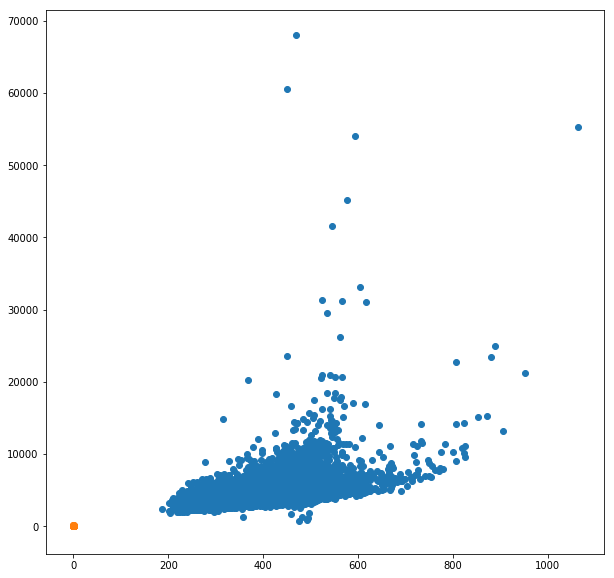

11.02570703022157
11.0925780581 4.60410230466


(83.446881278650835, 10.840741384081582)

In [61]:
fit_variance(peaks)

In [51]:
expt = nsx.Experiment('test', 'BioDiff2500')
#expt = nsx.Experiment('test', 'D19')
diff = expt.getDiffractometer()
reader = nsx.HDF5DataReader("/home/jonathan/data/biodiff/p11202/p11202_new.hdf", diff)
#reader = nsx.HDF5DataReader("/home/jonathan/data/d19/d19_reference_data/125562.h5", diff)
data = nsx.DataSet(reader, diff)
expt.addData(data)

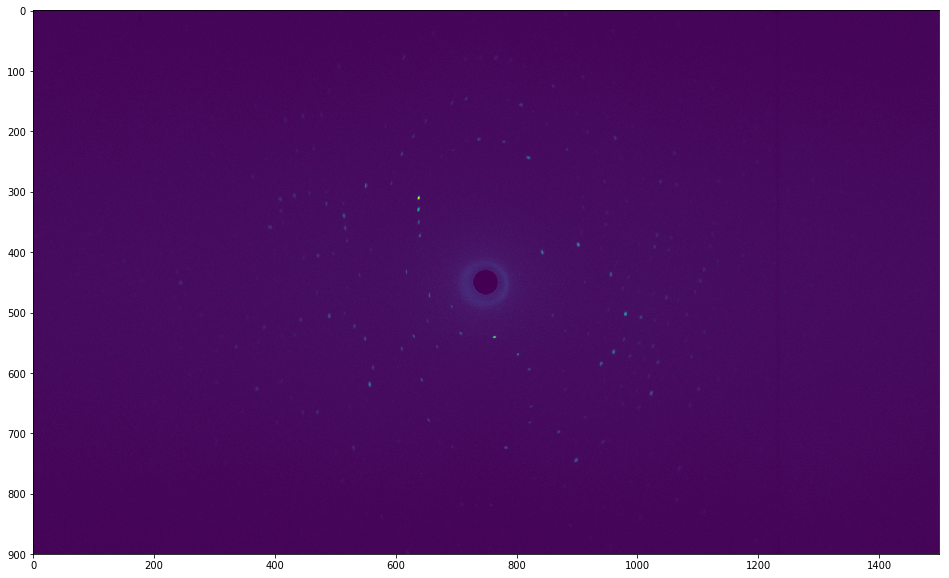

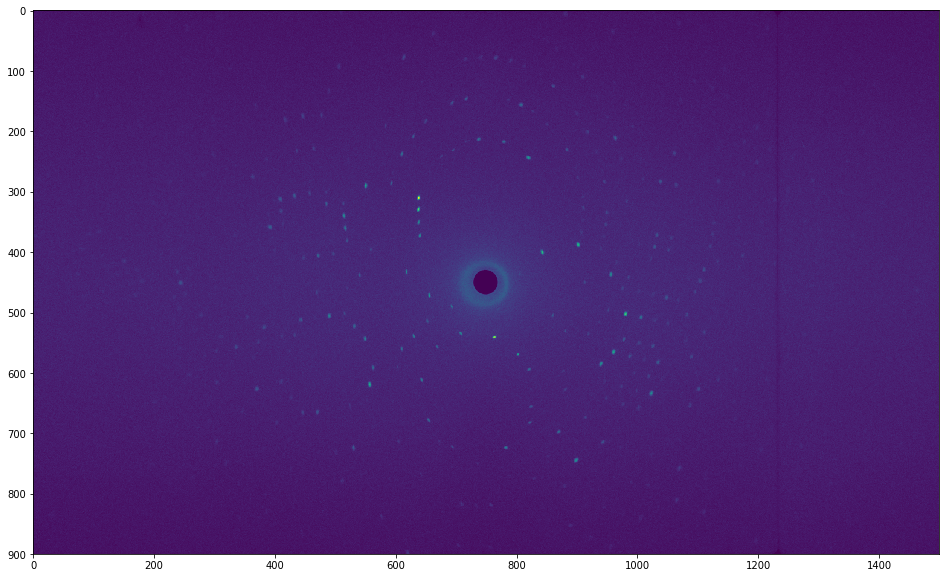

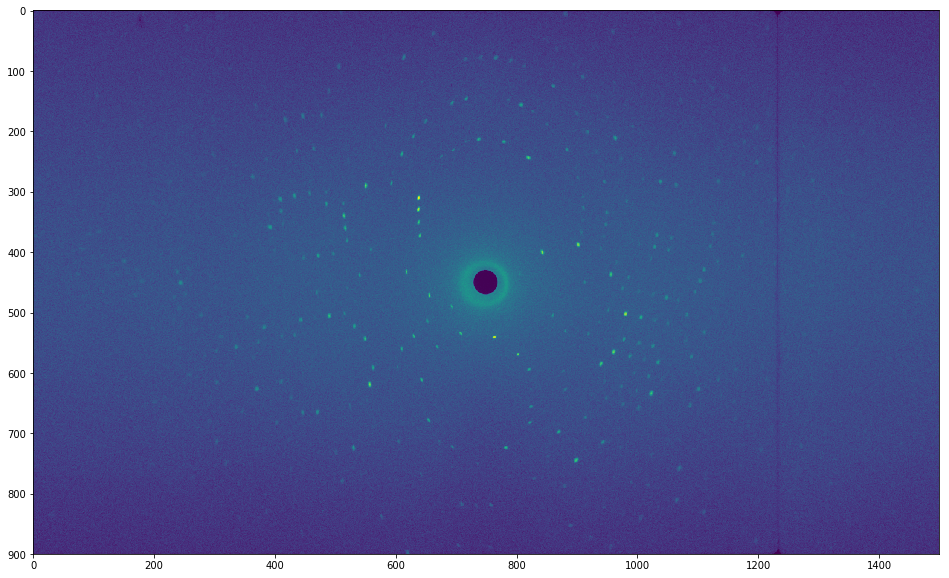

In [52]:
frameno = 0
image = data.getFrame(frameno)[:,500:2000]

plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()

vimage = variance_transform(image)

plt.figure(figsize=(20,10))
plt.imshow(vimage)
plt.show()

limage = np.log(image)

plt.figure(figsize=(20,10))
plt.imshow(limage)
plt.show()


#print(image.mean(), image.std()**2, image.std() / image.mean())
#print(vimage.mean(), vimage.std()**2, vimage.std() / vimage.mean())
#print(limage.mean(), limage.std()**2, limage.std() / limage.mean())

#print(limage.std()**2, image.std()**2/image.mean()**2)

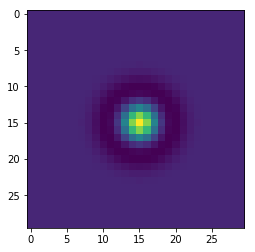

In [149]:
n = 30
sigma = 1.5

x = np.array(range(n)) - n/2
y = np.array(range(n)) - n/2

xx, yy = np.meshgrid(x, y)

r = np.sqrt(xx*xx + yy*yy)

#kernel = (1-(xx*xx+yy*yy)/sigma/sigma)*np.exp(-(xx*xx+yy*yy) / 2.0 / sigma / sigma)
positive = np.exp(-r*r/ 2.0 / sigma / sigma)
positive /= positive.mean()

negative = np.exp(-(r-3*sigma)**2/2.0 / sigma/ sigma)
negative /= negative.mean()

kernel = positive - negative

kernel -= kernel.mean()

plt.imshow(kernel)
plt.show()

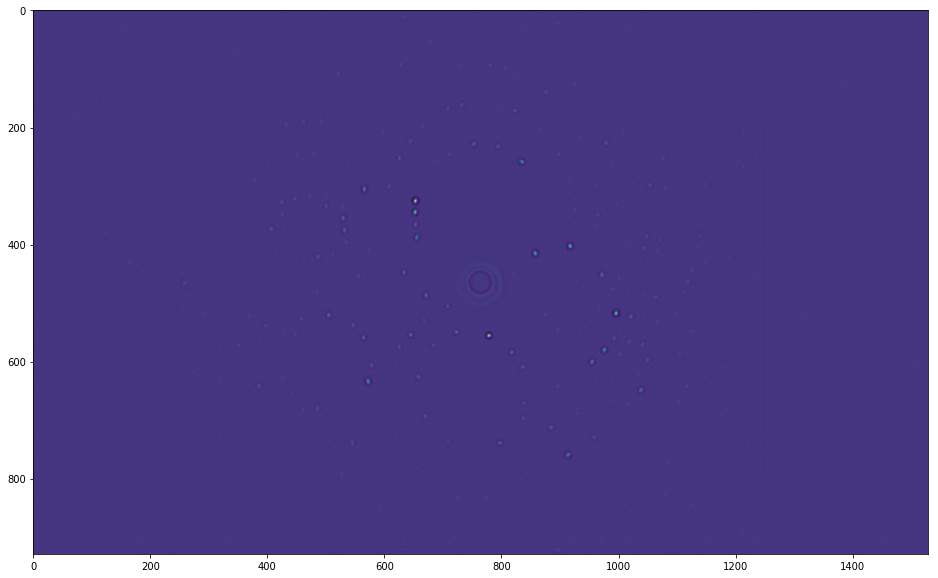

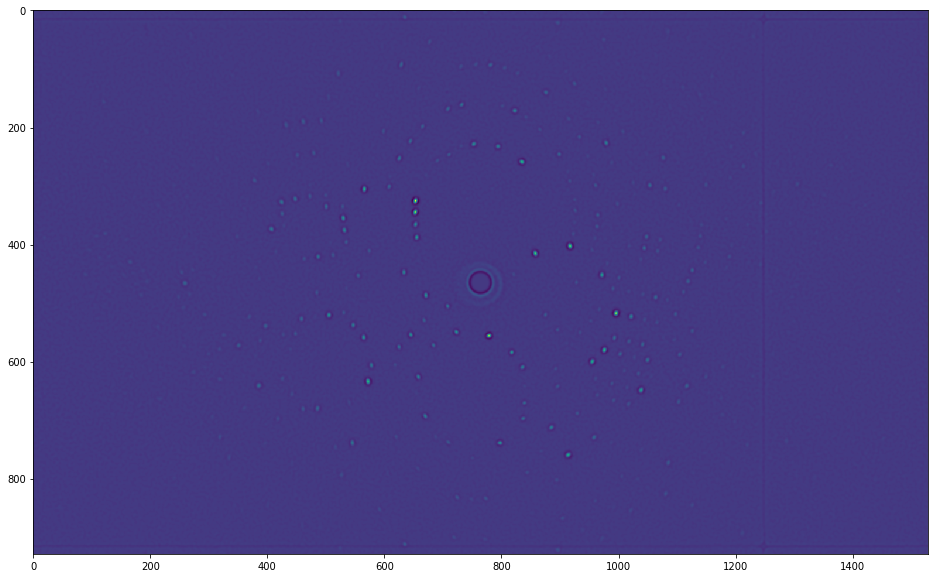

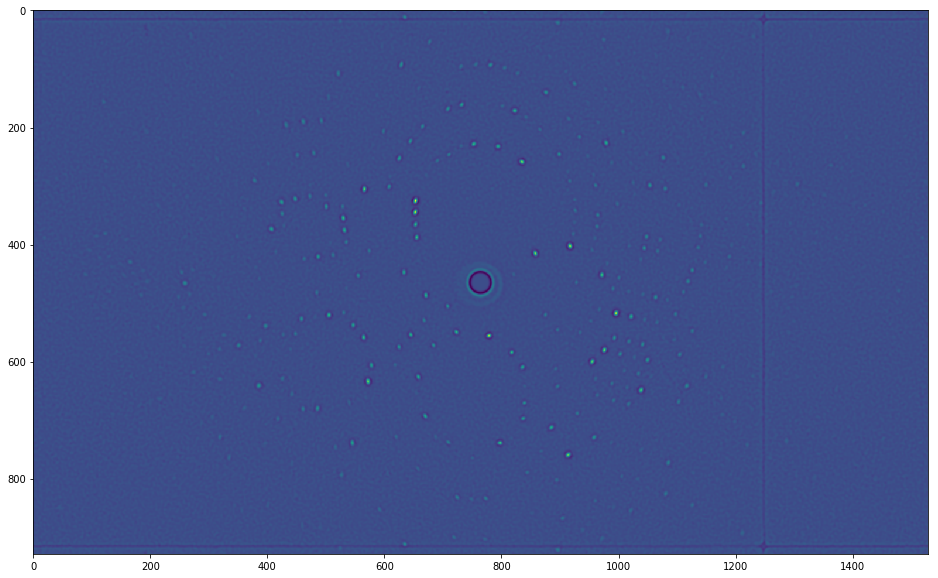

In [156]:
result = scipy.signal.convolve2d(image, kernel, boundary='wrap')
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.show()

result_ans = scipy.signal.convolve2d(variance_transform(image), kernel, boundary='wrap')
plt.figure(figsize=(20,10))
plt.imshow(result_ans)
plt.show()

result_log = scipy.signal.convolve2d(np.log(image), kernel, boundary='wrap')
plt.figure(figsize=(20,10))
plt.imshow(result_log)
plt.show()

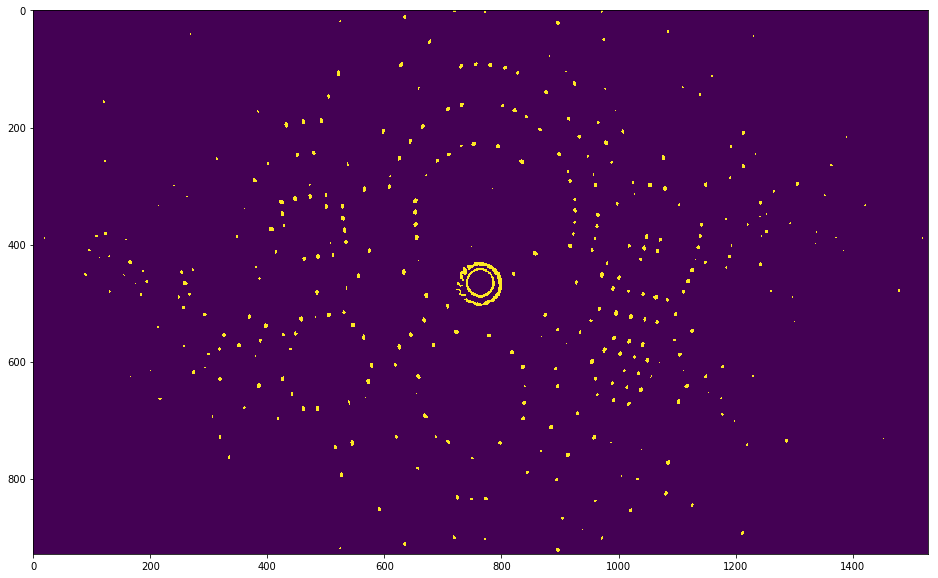

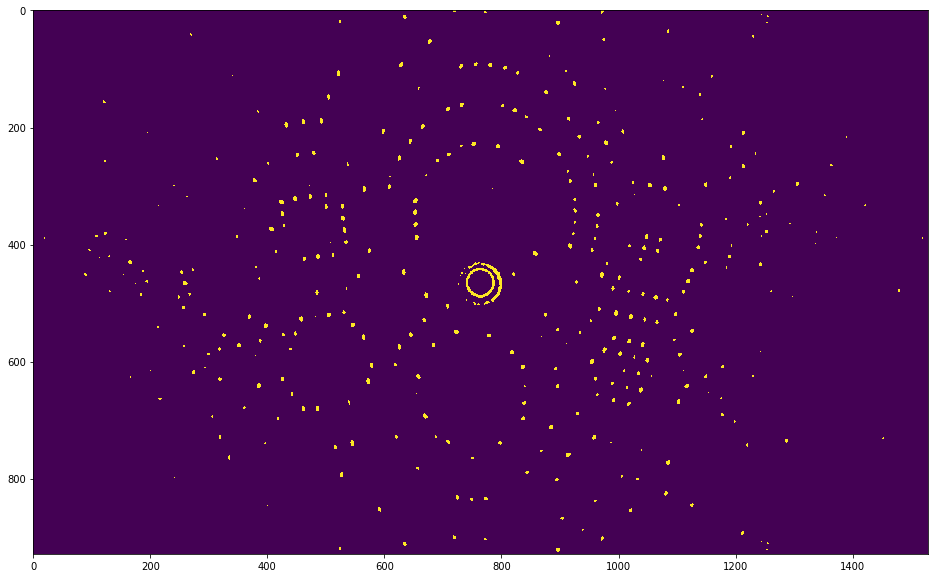

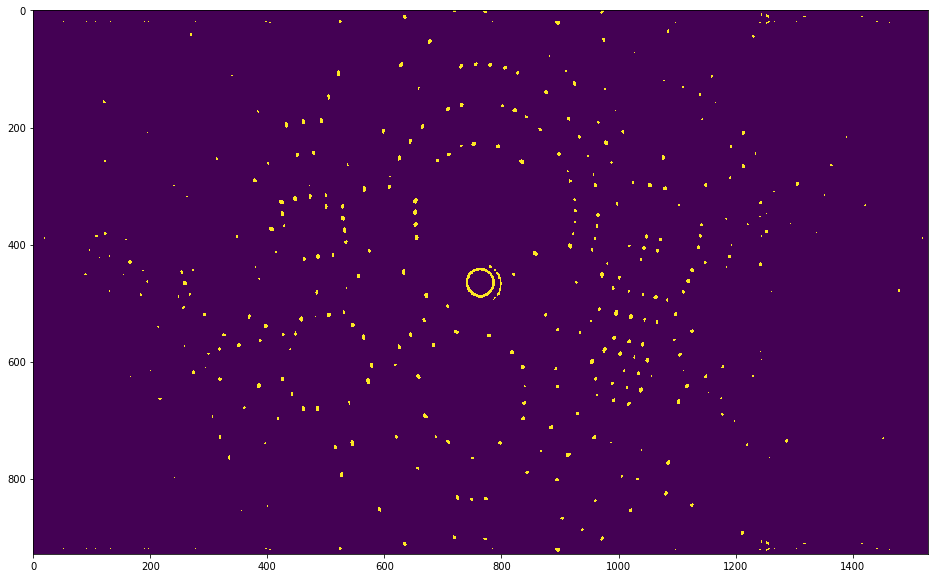

In [161]:
threshold = result > 50000.0
threshold_ans = result_ans > 2000.0
threshold_log = result_log > 85.0


plt.figure(figsize=(20,10))
plt.imshow(threshold)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(threshold_ans)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(threshold_log)
plt.show()

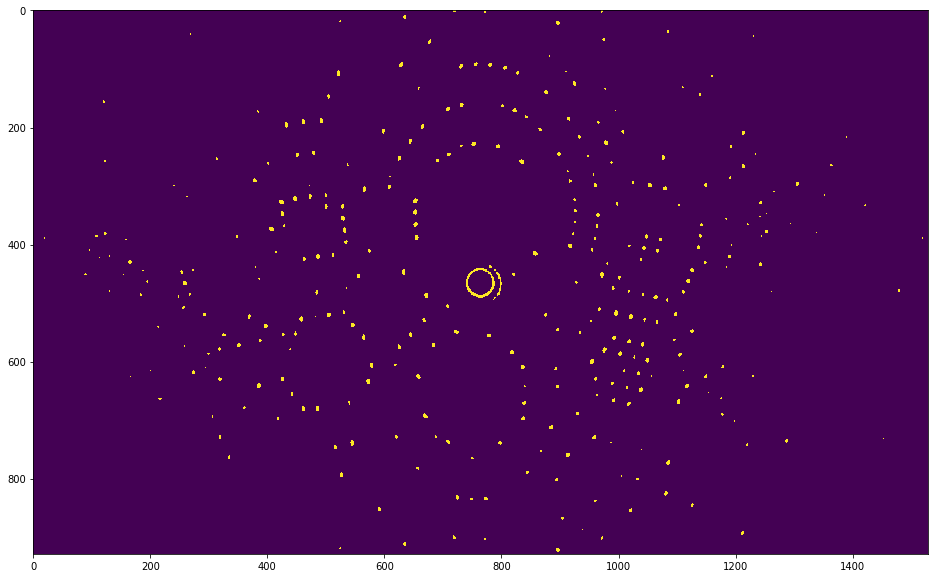

In [164]:
plt.figure(figsize=(20,10))
plt.imshow(threshold_log*threshold)
plt.show()

In [116]:
%matplotlib tk
plt.imshow(result > 10000)
plt.show()

In [53]:
kernel = nsx.AnnularKernel(data.getNRows(), data.getNCols())
kernel_image = kernel.getKernel()
convolver = nsx.Convolver()
convolver.setKernel(kernel_image)

In [54]:
finder = nsx.PeakFinder()
finder.setConvolver(convolver)
finder.setMinComponents(30)
finder.setMaxComponents(10000)
finder.setSearchConfidence(0.67)
finder.setIntegrationConfidence(0.98)
finder.setThresholdType(1)
finder.setThresholdValue(80.0)
finder.setKernel(kernel)

In [55]:
numors = nsx.vector_data()
numors.push_back(data)
peaks = finder.find(numors)
print(peaks.size())

9203


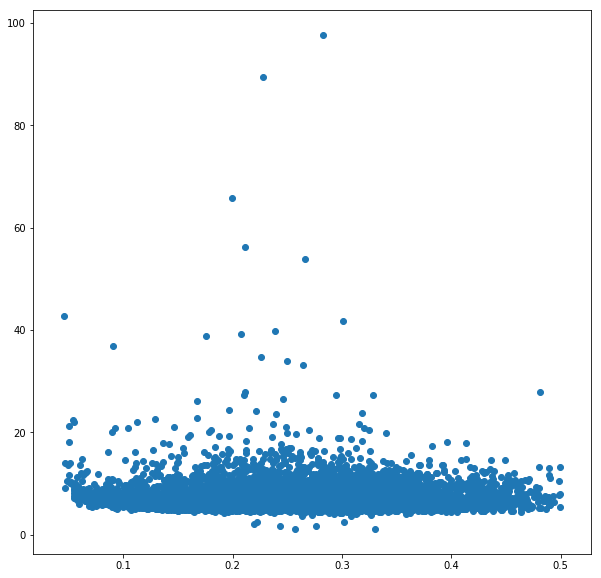

7.307056584935564
7.20811265623 3.08753432822


(-2377.401412907755, 10.840741384081525)

In [56]:
fit_variance(peaks)

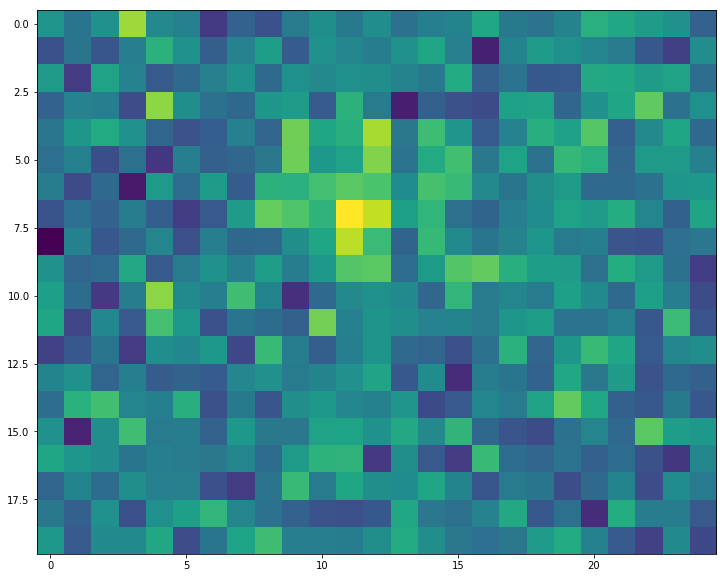

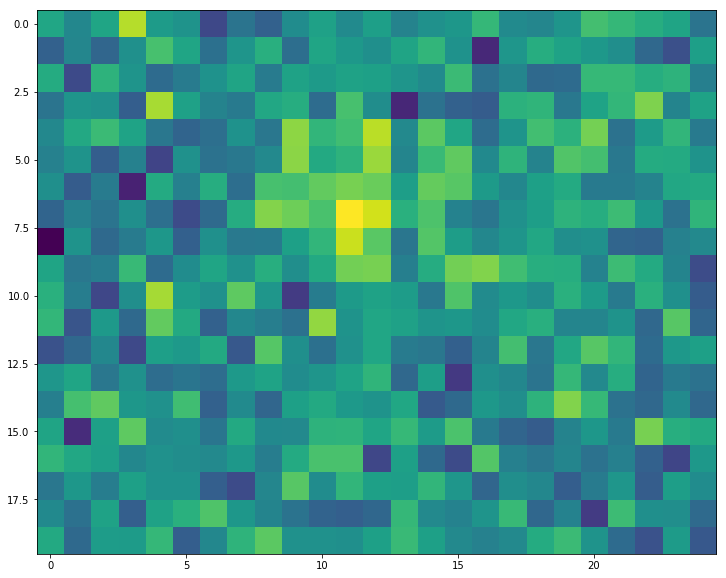

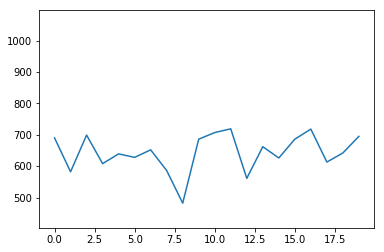

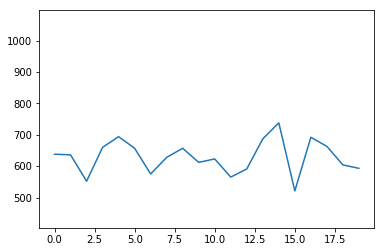

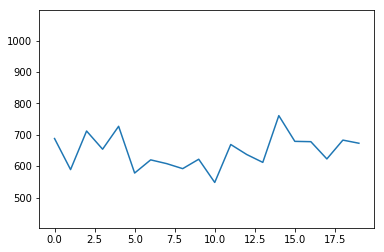

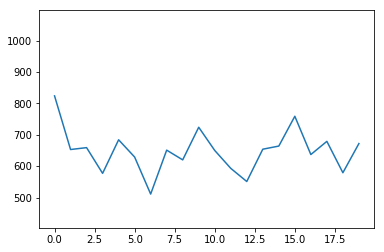

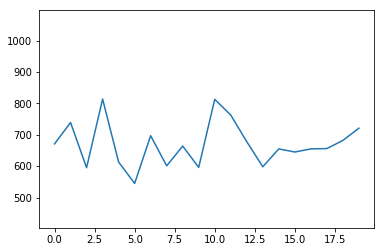

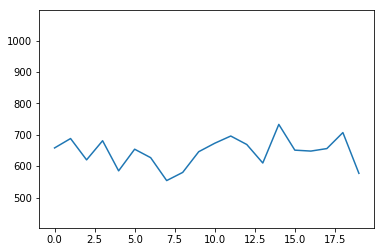

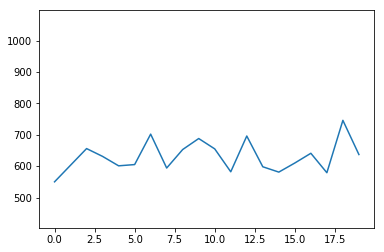

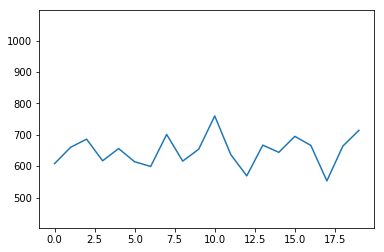

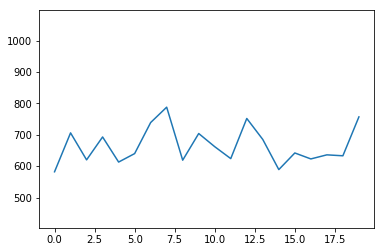

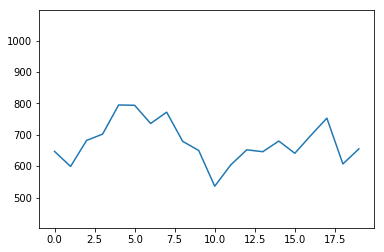

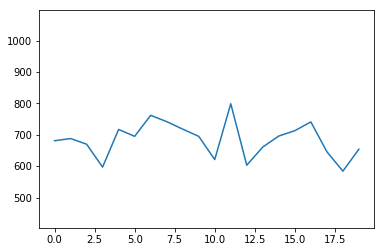

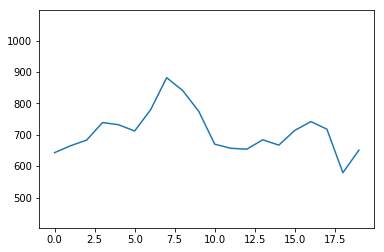

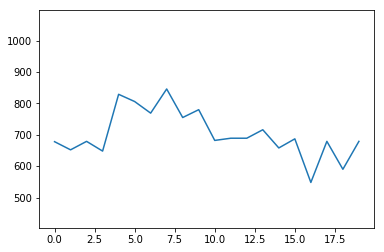

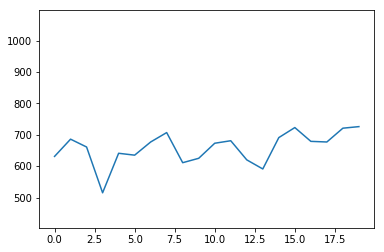

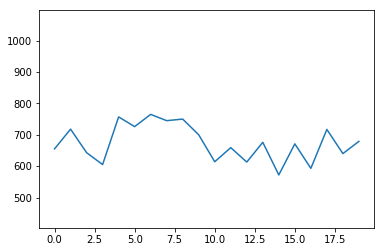

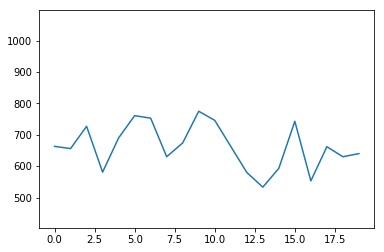

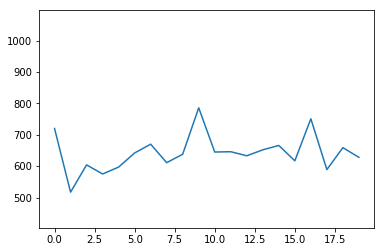

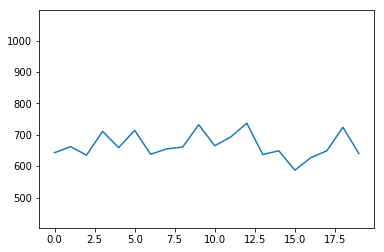

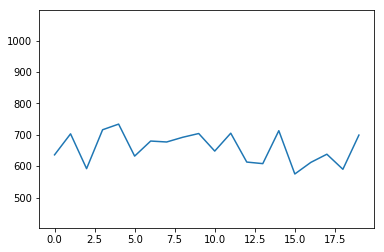

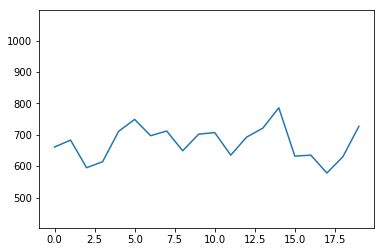

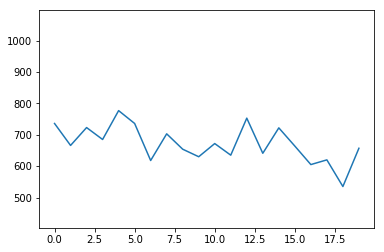

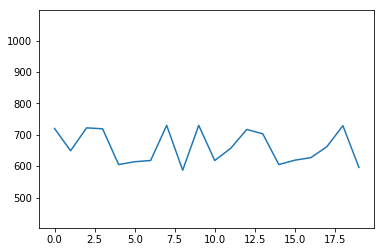

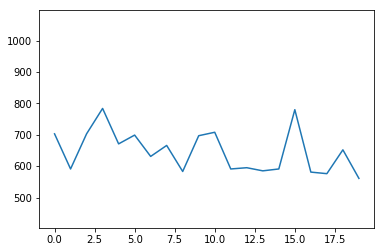

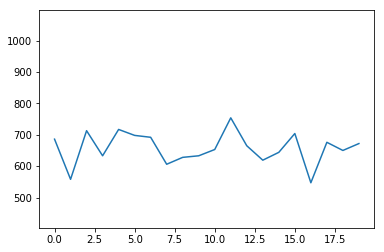

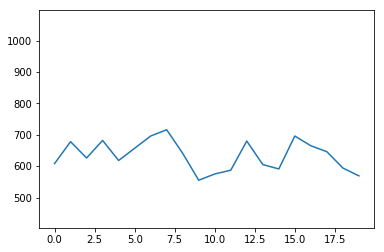

In [39]:
weak_peak = data.getFrame(100)[450:470, 715:740]

fig = plt.figure(figsize=(20,10))
plt.imshow(weak_peak)
plt.show()

fig = plt.figure(figsize=(20,10))
plt.imshow(np.log(weak_peak))
plt.show()


for f in range(weak_peak.shape[]):
    plt.plot(weak_peak[:,f])
    ax = plt.gca()
    ax.set_ylim(np.exp(6), np.exp(7))
    plt.show()


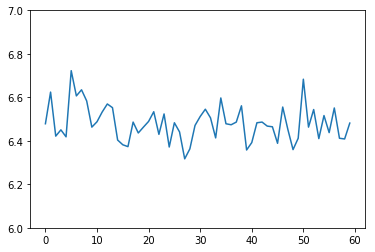

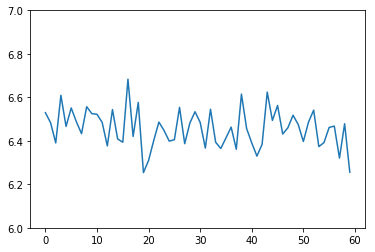

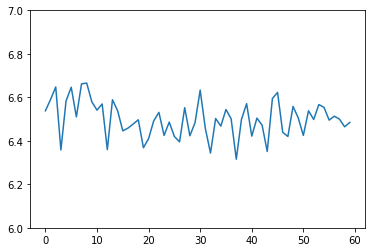

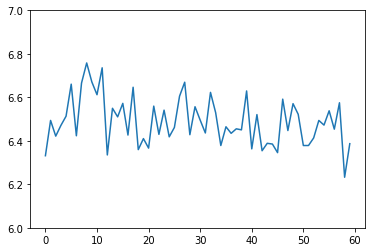

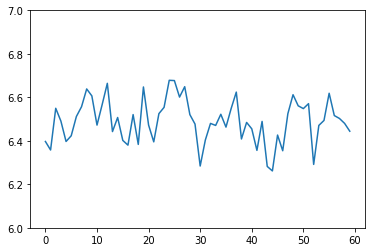

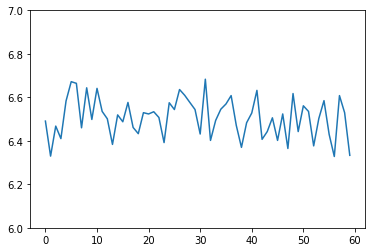

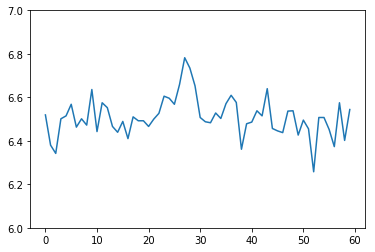

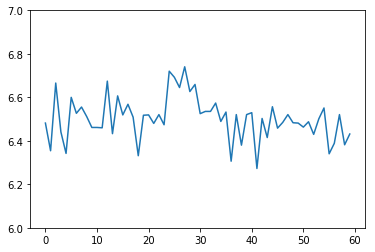

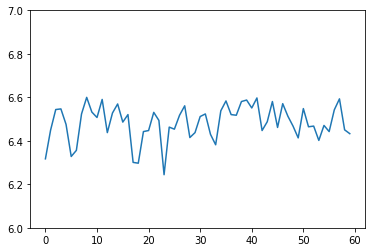

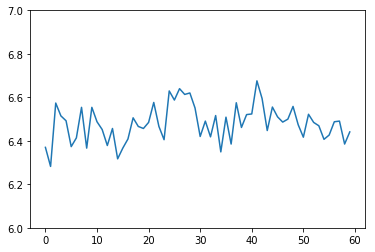

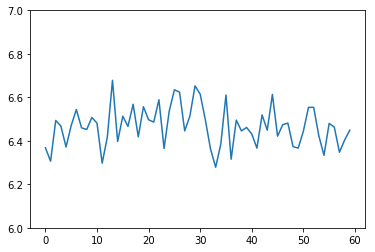

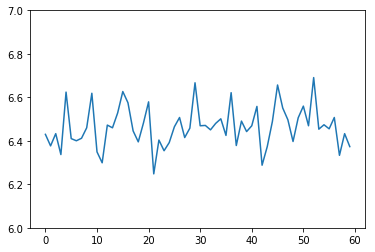

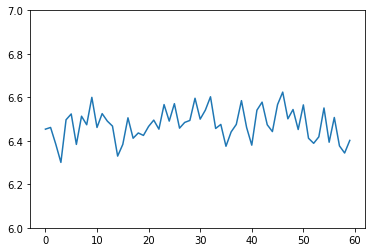

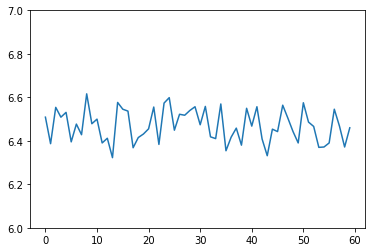

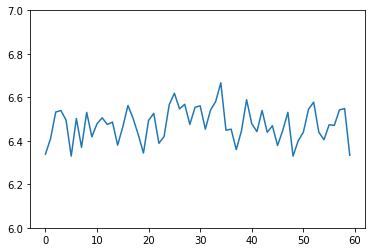

In [31]:
lweak = np.log(weak_peak)

for f in range(20, 35):
    plt.plot(lweak[:,f])
    ax = plt.gca()
    ax.set_ylim(6, 7)
    plt.show()


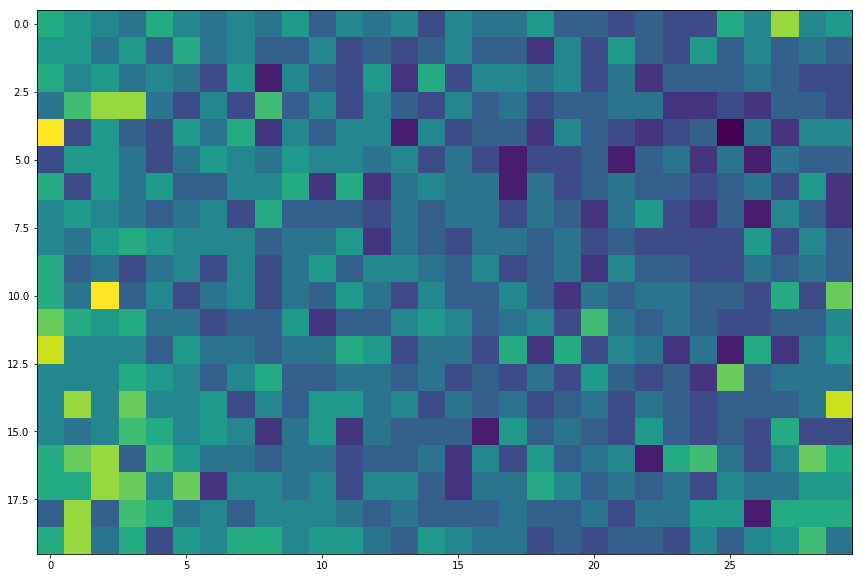

227.053333333 2.02661184136


In [49]:
image = data.getFrame(0)[440:460,1235:1265]

fig = plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()

print(image.mean(), image.std())

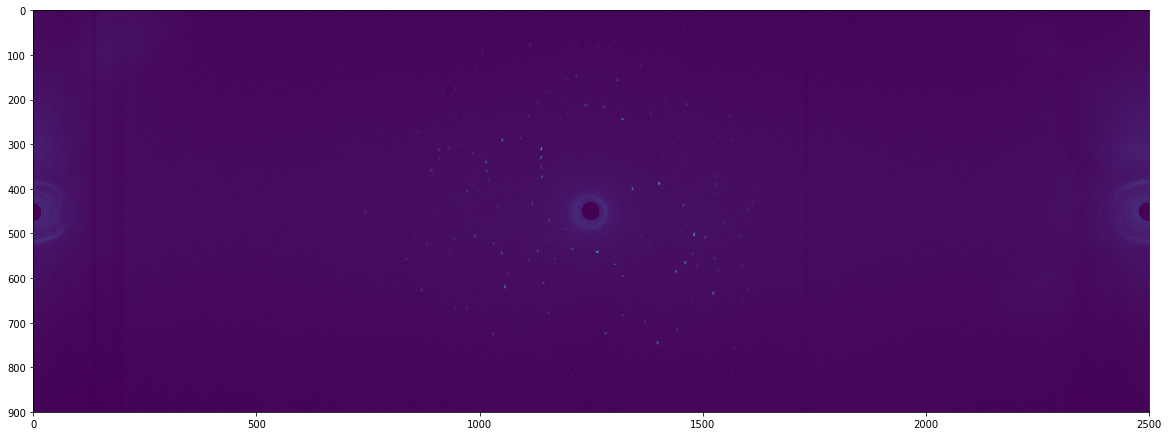

570.037584444 167.55920437


In [50]:
image = data.getFrame(0)#[440:460,1235:1265]

fig = plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()

print(image.mean(), image.std())

In [25]:
I = 0.0
I2 = 0.0

for peak in peaks:
    intensity = peak.getCorrectedIntensity().getValue()
    I += intensity
    I2 += intensity**2
    
I /= peaks.size()

variance = (I2 - peaks.size()*I*I) / (peaks.size()-1)
std = math.sqrt(variance)

print("average intensity =", I)
print("std intensity     =", std)

NameError: name 'peaks' is not defined

In [ ]:
I = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().getValue())
    q.append(np.linalg.norm(peak.getQ()))

plt.figure(figsize=(15,15))
plt.scatter(q, I, s=0.2)
plt.show()

In [ ]:
indexer = nsx.AutoIndexer(expt, nsx.ProgressHandler())

num_to_index = 0

for peak in peaks:
    d = 1.0 / np.linalg.norm(peak.getQ())
    if peak.isSelected() and d > 2.0 and d < 45.0:
        indexer.addPeak(peak)
        num_to_index += 1

print("indexing", num_to_index, "peaks")
        
params = nsx.IndexerParameters()
handler = nsx.ProgressHandler()
indexer.autoIndex(params)

soln = indexer.getSolutions()[0]
assert(soln[1] > 92.0)

uc = nsx.UnitCell(soln[0])
sample = biodiff.getSample()
sample.addUnitCell(uc)

for peak in peaks:
    peak.addUnitCell(uc, True)

predict_peaks(data)

In [ ]:
I = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    I.append(peak.getCorrectedIntensity().getValue())
    q.append(np.linalg.norm(peak.getQ()))

plt.figure(figsize=(7,7))
plt.scatter(q, I, s=0.2)
plt.show()

In [ ]:
peaks = data.getPeaks()


# apply some cutoffs to the peaks
for peak in peaks:
    if peak.isSelected() != True:
        continue
    if peak.pValue() > 0.001:
        peak.setSelected(False)
        continue


P = []
q = []

for peak in peaks:
    if peak.isSelected() != True:
        continue
    P.append(peak.pValue())
    q.append(np.linalg.norm(peak.getQ()))
    
print(len(P), "peaks")

plt.figure(figsize=(15,15))
plt.scatter(q, P, s=0.2)
plt.show()

In [ ]:
# apply some cutoffs to the peaks
num_peaks = 0
for peak in peaks:
    if peak.isSelected() != True:
        continue
        
    prof = nsx.Profile()
    if prof.fit(peak.getIntegration().getProjectionPeak()) == False:
        peak.setSelected(False)
        continue
        
    num_peaks += 1

print(num_peaks)

In [ ]:
n = 3001

peak = peaks[n]
prof = peak.getProfile()

zs = peak.getIntegration().getProjectionPeak().transpose()[0]
qs = [ z for z in zs]
xs = [x for x in range(len(qs))]

print(xs)
print(zs)

ws = np.linspace(xs[0], xs[-1:])

if not prof.fit(zs,1000):
    print("PROFILE FIT FAILED")
    
ys = [prof.evaluate(w) for w in ws ]

plt.plot(ws, ys)
plt.show()

plt.scatter(xs, qs)
plt.show()

calc = [prof.evaluate(x) for x in xs]

print("obs:  ", peak.getRawIntensity().getValue())
print("calc: ", sum(calc))
print("sum:  ", sum(qs))

In [ ]:
help(nsx.PeakIntegrator)

In [ ]:
[1,2,3,4][-1:]

In [ ]:
nsx.PeakCalc(peaks[0])

In [ ]:
compute_statistics(peaks, nsx.SpaceGroup("P 21 21 21"), True)

In [ ]:
high_q_peaks = []

for peak in peaks:
    if peak.isSelected() == False:
        continue
    if 1.0 / np.linalg.norm(peak.getQ()) < 2.1:
        high_q_peaks.append(peak)
        
print(len(high_q_peaks))
print(compute_statistics(peaks, nsx.SpaceGroup("P 21 21 21"), True))

In [ ]:
for i in range(1):
    print('------------------------------------------')
    print(num_selected_peaks(data.getPeaks()))
    filter_peaks(data.getPeaks())
    remove_deselected(data)
    print(num_selected_peaks(data.getPeaks()))
    predict_peaks(data)
    print(num_selected_peaks(data.getPeaks()))
    print(compute_statistics(data.getPeaks(), nsx.SpaceGroup("P 21 21 21"), True))

In [ ]:
dmin = 2.1
dmax = 48.0

good_peaks = []
all_peaks = data.getPeaks()
filter_peaks(all_peaks)

for peak in all_peaks:
    if not peak.isSelected():
        continue
        
    d = 1.0 / np.linalg.norm(peak.getQ())
    if d >= dmin and d <= dmax:
        good_peaks.append(peak)
          
print(len(all_peaks))
print(len(good_peaks))

compute_statistics(good_peaks, nsx.SpaceGroup("P 21 21 21"), True)

In [ ]:
merged = nsx.MergedData(nsx.SpaceGroup("P 21 21 21"), True)

for peak in good_peaks:
    if peak.isSelected():
        merged.addPeak(nsx.PeakCalc(peak))
        
p = []
q = []
        
for peak in merged.getPeaks():
    p.append(peak.chi2()) 
    [[h, k, l]] = peak.getIndex()
    q.append(1.0 / uc.getD(int(h),int(k),int(l)))
        
    
plt.figure(figsize=(15,15))
plt.scatter(q, p, s=0.2)
plt.show()

In [ ]:
peak = merged.getPeaks()[1]
raw_peaks = peak.getPeaks()

In [ ]:
print(raw_peaks)
print(type(raw_peaks))

In [ ]:
help(nsx.PeakCalc)

In [ ]:
help(uc)

In [ ]:
peak.getIndex()

In [ ]:
peaks = data.getPeaks()
qs = []

for peak in peaks:
    qs.append(peak.getQ()[0])
    
xs = [ q[0] for q in qs ]
ys = [ q[1] for q in qs ]
zs = [ q[2] for q in qs ]

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs, ys, zs, s=0.1)
plt.show()
      

In [ ]:
hs = []
ks = []
ls = []
error = []
frame = []

the_peaks = [peaks[0]]

for peak in peaks:
    if not peak.isSelected():
        continue
    
    center = peak.getShape().getAABBCenter().transpose()[0]
    
    q = peak.getQ()
    hkl = peak.getMillerIndices()[0]
    
    uc = peak.getActiveUnitCell()
    g = uc.getMetricTensor()
    
    real_hkl = uc.fromReciprocalStandard(q)[0]
    
    d = real_hkl-hkl
    
    if (np.linalg.norm(d) > 0.5):
        continue
    
    #print(hkl)
    #print(real_hkl)
    
    hs.append(d[0])
    ks.append(d[1])
    ls.append(d[2])
    error.append(np.linalg.norm(d))
    frame.append(center[2])

In [ ]:
plt.figure(figsize=(15,15))
#plt.scatter(frame, hs, s=0.5, color='r')
#plt.scatter(frame, ks, s=0.5, color='g')
#plt.scatter(frame, ls, s=0.5, color='b')
plt.scatter(frame, error, s=0.5, color='b')
plt.show()